Import needed libraries

In [1]:
from filters import DoGFilter, GaborFilter
from Encoders import TimeToFirstSpikeEncoding, Poisson
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

In [15]:
# Function to apply the filter to an image
def apply_filter(image, filter):
    # Convert image to torch tensor
    image_tensor = torch.tensor(image, dtype=torch.float32)
    
    # Apply the filter using convolution
    filter_size = filter.shape[0]
    padding = filter_size // 2
    image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    filter = filter.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    filtered_image = torch.nn.functional.conv2d(image_tensor, filter, padding=padding)
    
    return filtered_image.squeeze().numpy()


# read an image and convert it to torch tensor
def image_to_vec(img1, size=(10, 10)):
    img = cv2.resize(img1, (size[0], size[1]))
    img = torch.from_numpy(img)
    # img = img.sum(2)//3

    return img



def show_image(img):
    plt.imshow(img, cmap='gray')  
    plt.show()


def raster_plot(spikes, fsize=(5,5)):
    
    plt.figure(figsize=fsize)
    plt.xlim(0, len(spikes))
    s_spikes = torch.nonzero(spikes)
    plt.scatter(s_spikes[:,0], s_spikes[:,1], s=2, c='darkviolet')
    
        
    plt.xlabel("Time")
    plt.ylabel("Neurons")
    plt.show()

def visualize_spikes(spikes, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(spikes.sum(dim=0).cpu().numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

Load the Images

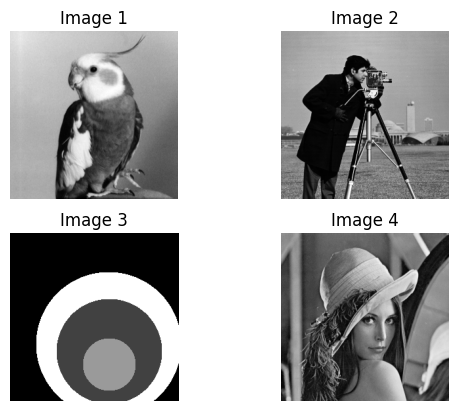

In [3]:
image1 = cv2.imread('images/bird.tif', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('images/camera.tif', cv2.IMREAD_GRAYSCALE)
image3 = cv2.imread('images/circles.tif', cv2.IMREAD_GRAYSCALE)
image4 = cv2.imread('images/lena1.tif', cv2.IMREAD_GRAYSCALE)
images = [image1, image2, image3, image4]

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.title(f'Image {i}')
    plt.imshow(images[i-1], cmap='gray')
    plt.axis('off')

# DoG Filter

In [4]:
on_center_dog_filter = DoGFilter(size=15, sigma_1=1.0, sigma_2=5.0, dtype=torch.float32)
off_center_dog_filter = DoGFilter(size=5, sigma_1=3.0, sigma_2=1.0, dtype=torch.float32)

apply filters

In [5]:
on_filtered_images = []
for i in range(1, 5):
    on_filtered_images.append(apply_filter(images[i-1], on_center_dog_filter))

off_filtered_images = []
for i in range(1, 5):
    off_filtered_images.append(apply_filter(images[i-1], off_center_dog_filter))

Display the results

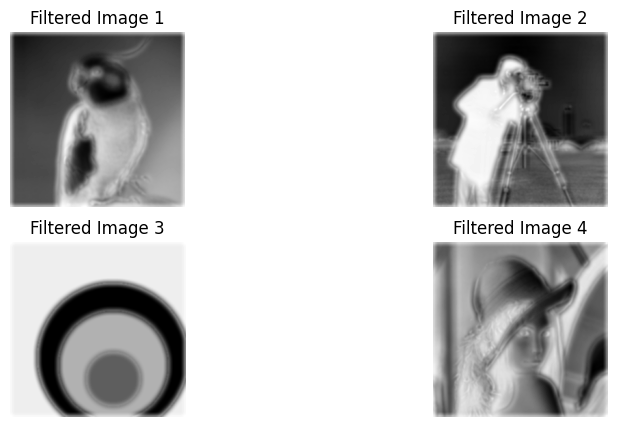

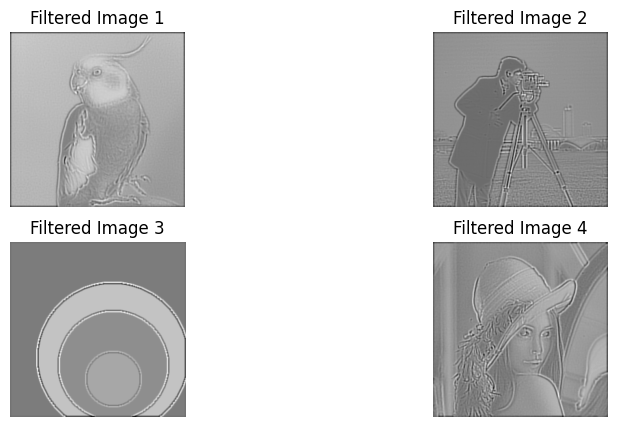

In [6]:
plt.figure(figsize=(10, 5))

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.title(f'Filtered Image {i}')
    plt.imshow(on_filtered_images[i-1], cmap='gray')
    plt.axis('off')

plt.show()

plt.figure(figsize=(10, 5))

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.title(f'Filtered Image {i}')
    plt.imshow(off_filtered_images[i-1], cmap='gray')
    plt.axis('off')

plt.show()

# Gabor Filter

In [6]:
gabor_filter = GaborFilter(size=20, labda=10.0, theta=np.pi/4, sigma=5.0, gamma=1.0, phi=0, dtype=torch.float32)

apply filters

In [7]:
filtered_images = []
for i in range(1, 5):
    filtered_images.append(apply_filter(images[i-1], gabor_filter))


Display the Results

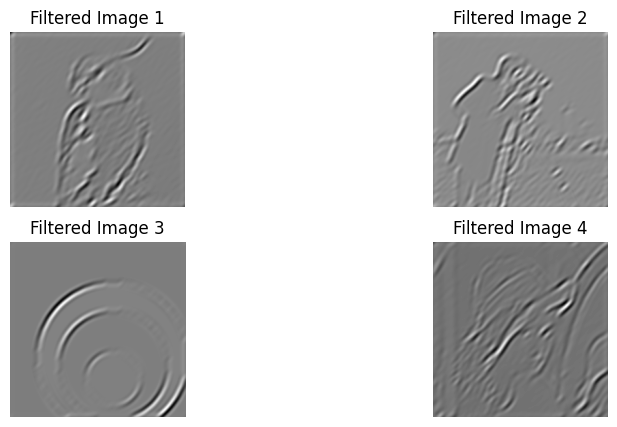

In [9]:
plt.figure(figsize=(10, 5))

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.title(f'Filtered Image {i}')
    plt.imshow(filtered_images[i-1], cmap='gray')
    plt.axis('off')

plt.show()

# Time-To-First-Spike Encoding

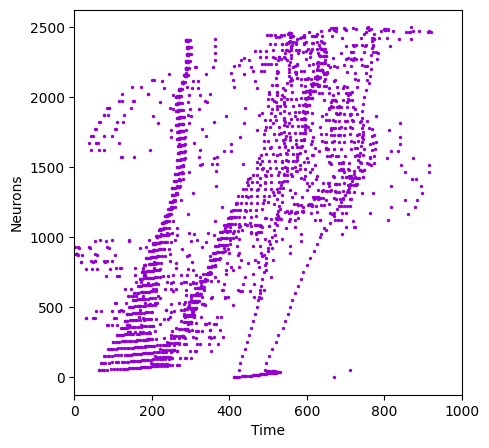

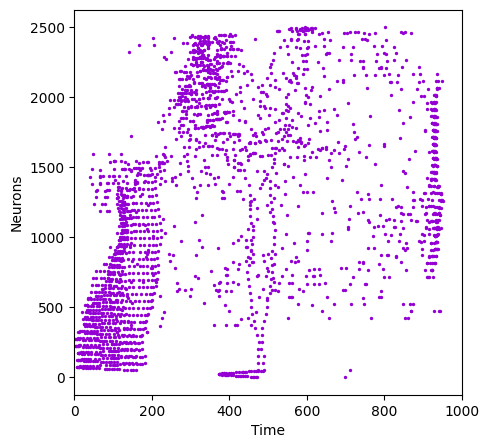

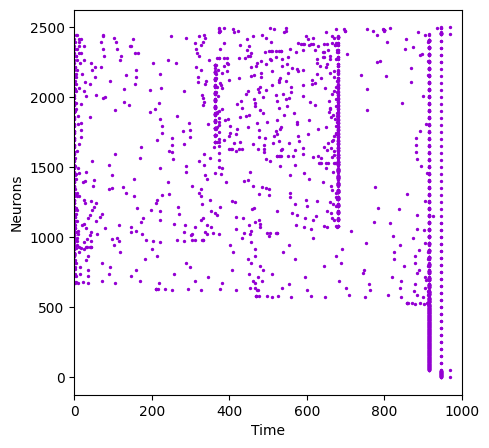

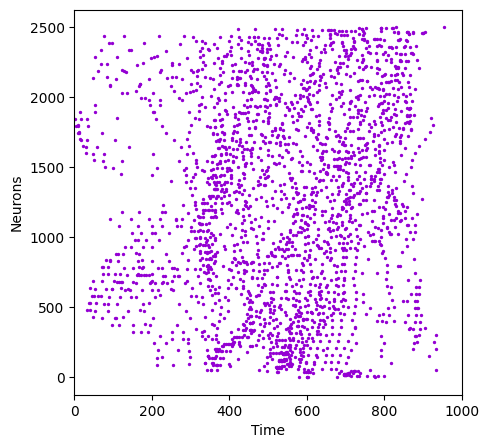

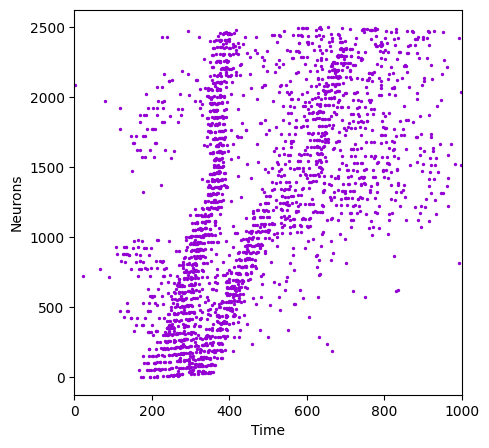

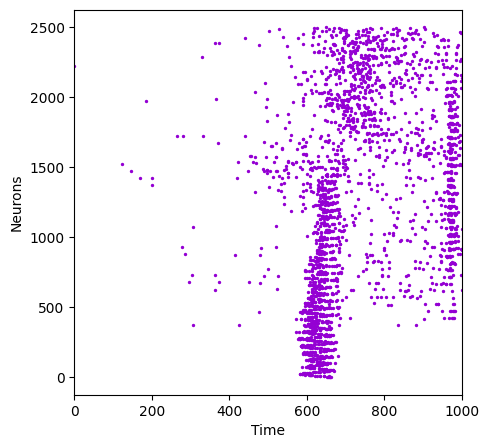

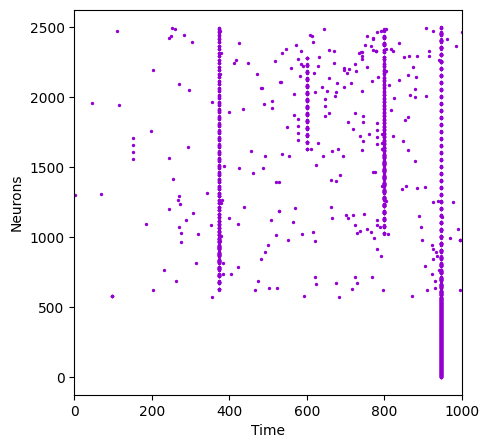

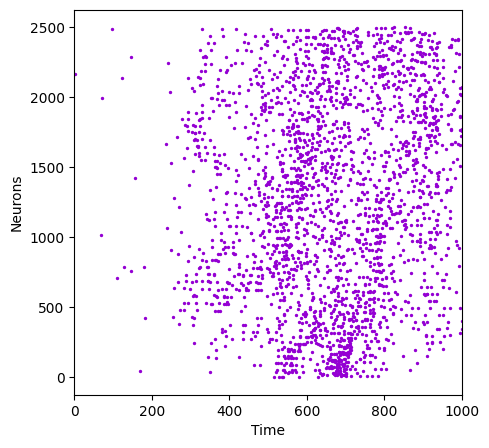

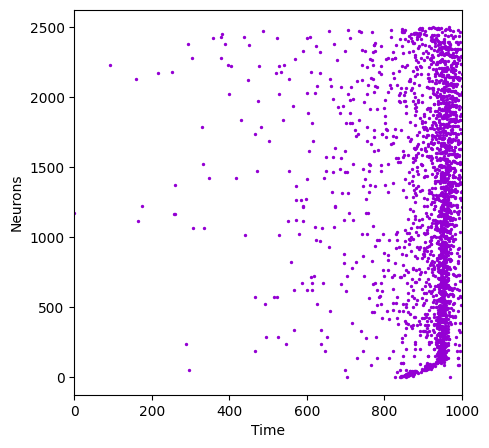

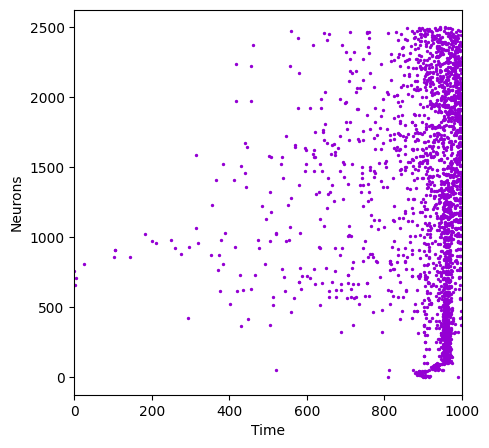

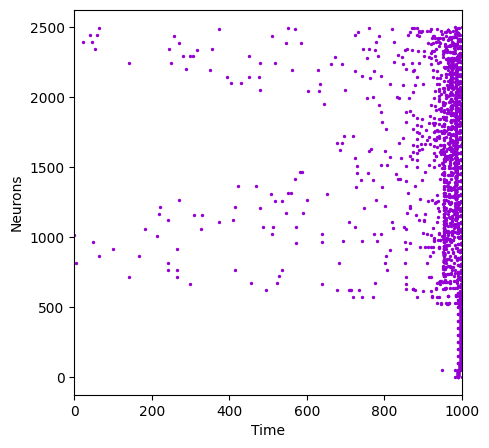

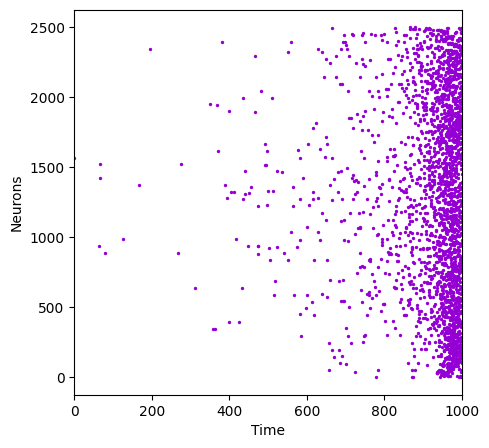

In [22]:
ttfs_on_dogs, ttfs_off_dogs, ttfs_gabor = [], [], []
for i in range(4):
    img = image_to_vec(on_filtered_images[i], (50, 50))
    ttfs = TimeToFirstSpikeEncoding(img, 1000)
    ttfs_on_dogs.append(ttfs.encode())


    img = image_to_vec(off_filtered_images[i], (50, 50))
    ttfs = TimeToFirstSpikeEncoding(img, 1000)
    ttfs_off_dogs.append(ttfs.encode())

    img = image_to_vec(filtered_images[i], (50, 50))
    ttfs = TimeToFirstSpikeEncoding(img, 1000)
    ttfs_gabor.append(ttfs.encode())

for pl in ttfs_on_dogs:
    raster_plot(pl)

for pl in ttfs_off_dogs:
    raster_plot(pl)

for pl in ttfs_gabor:
    raster_plot(pl)

# Poisson Encoding

Normalize outputs

In [11]:
normalized_on_dog, normalized_off_dog, normalized_gabor = [], [], []
for i in range(4):
    filtered_img_norm = (on_filtered_images[i] - on_filtered_images[i].min()) / (on_filtered_images[i].max() - on_filtered_images[i].min())
    # convert to torch tensors
    filtered_img_tensor = torch.tensor(filtered_img_norm, dtype=torch.float32)
    normalized_on_dog.append(filtered_img_tensor)

    filtered_img_norm = (off_filtered_images[i] - off_filtered_images[i].min()) / (off_filtered_images[i].max() - off_filtered_images[i].min())
    # convert to torch tensors
    filtered_img_tensor = torch.tensor(filtered_img_norm, dtype=torch.float32)
    normalized_off_dog.append(filtered_img_tensor)

    filtered_img_norm = (filtered_images[i] - filtered_images[i].min()) / (filtered_images[i].max() - filtered_images[i].min())
    # convert to torch tensors
    filtered_img_tensor = torch.tensor(filtered_img_norm, dtype=torch.float32)
    normalized_gabor.append(filtered_img_tensor)

In [18]:
# Create the Poisson encoder
poisson_encoder = Poisson(time_window=50, ratio=5.0)
# generate the spike trains
on_encoding, off_encoding, g_encoding = [], [], []
for i in range(4):
    spikes_image = poisson_encoder(normalized_on_dog[i])
    on_encoding.append(spikes_image)

    spikes_image = poisson_encoder(normalized_off_dog[i])
    off_encoding.append(spikes_image)

    spikes_image = poisson_encoder(normalized_gabor[i])
    g_encoding.append(spikes_image)


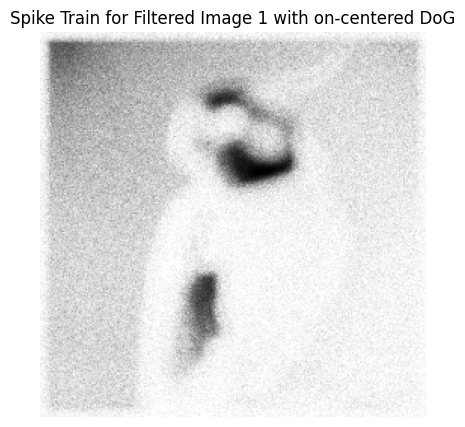

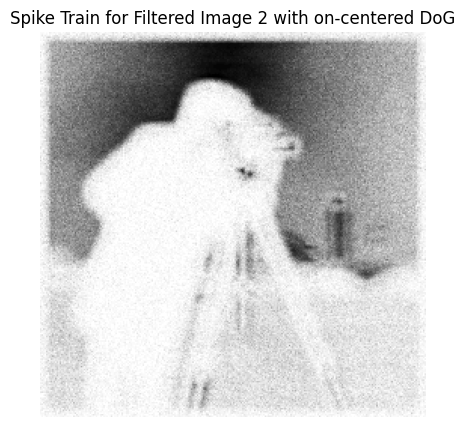

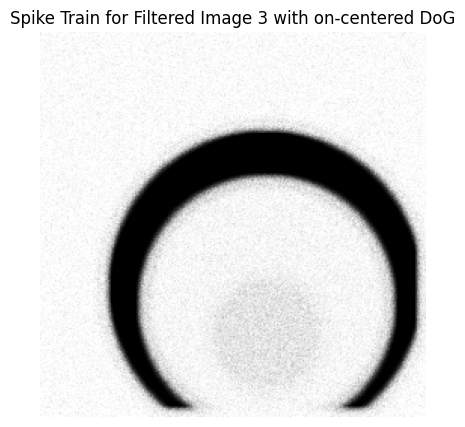

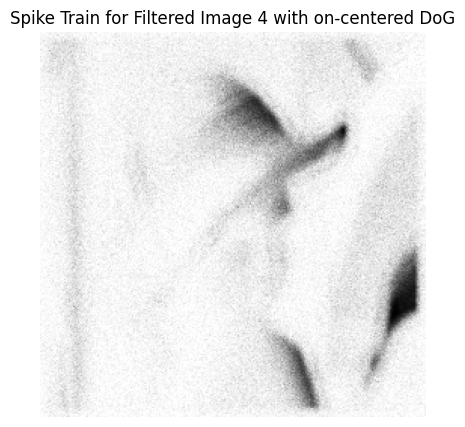

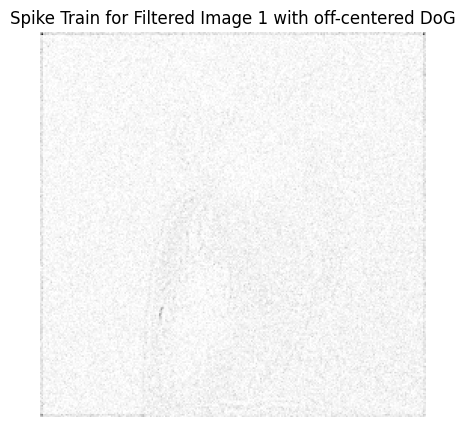

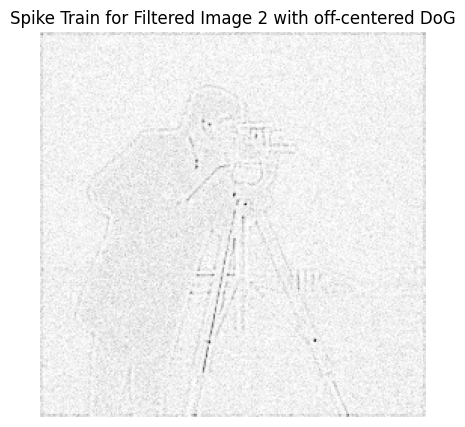

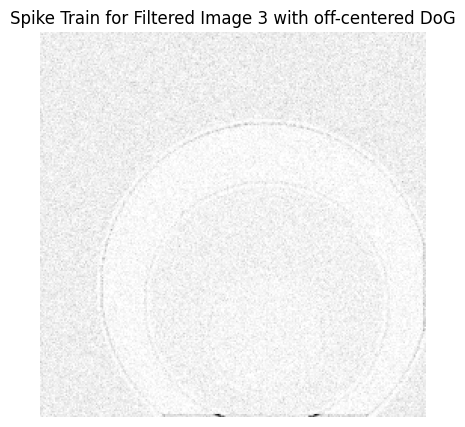

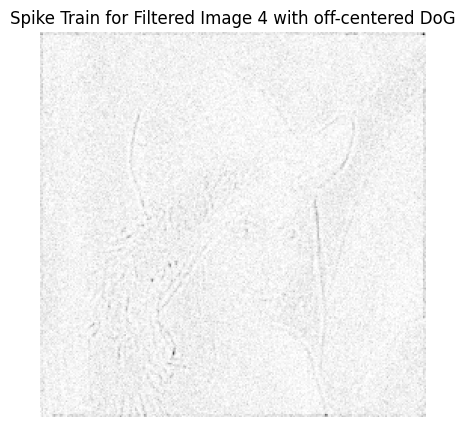

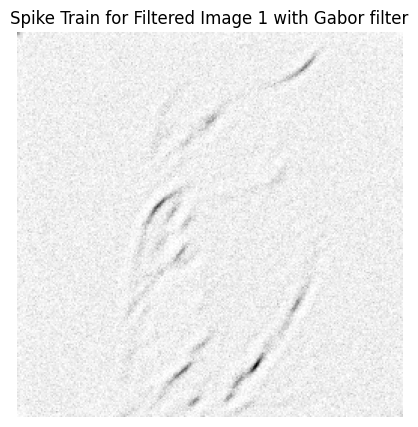

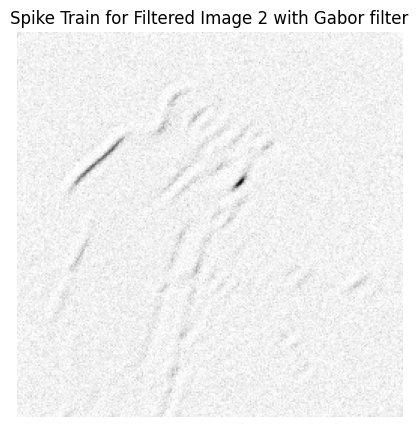

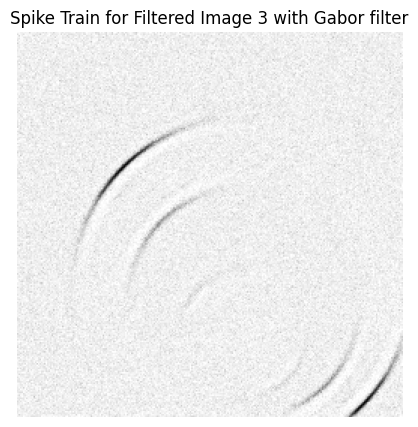

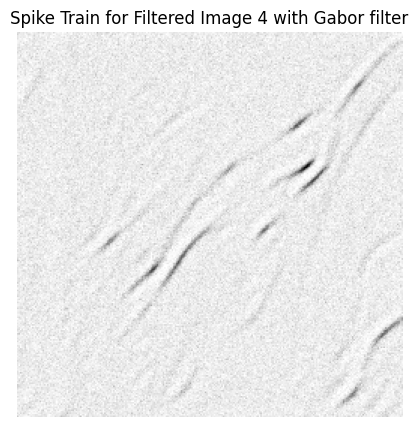

In [21]:
# Visualize the spike trains
for i in range(4):
    visualize_spikes(on_encoding[i], f'Spike Train for Filtered Image {i+1} with on-centered DoG')
    
for i in range(4):
    visualize_spikes(off_encoding[i], f'Spike Train for Filtered Image {i+1} with off-centered DoG')

for i in range(4):
    visualize_spikes(g_encoding[i], f'Spike Train for Filtered Image {i+1} with Gabor filter')
